# Bayesian parameter estimation for an LG-SSM using HMC

We show how to use the [Blackjax](https://github.com/blackjax-devs/blackjax) libray to approximate the parameter posterior distribution over parameters,
\begin{align*}
p(\theta \mid y_{1:T}) &\propto p(\theta) \, p(y_{1:T} \mid \theta).
\end{align*}
where 
\begin{align*}
p(y_{1:T} \mid \theta)
&= \int p(z_{1:T}, y_{1:T} \mid \theta) \, \mathrm{d}z_{1:T}
\end{align*} 
is the marginal likelihood of the observations under an LGSSM with parameters $\theta$. 
Dynamax computes the marginal log likelihood using the Kalman filter, and `jax.grad` automatically computes the gradient!

Hamiltonian Monte Carlo (HMC) is an MCMC method for generating approximate samples from the posterior distribution
by leveraging gradient information.
(See [Neal (2012)](https://arxiv.org/abs/1206.1901) for an introduction to HMC.)
The key idea is to define a Markov chain that updates the parameters by following
Hamiltonian dynamics on an energy function defined by the negative log joint probability,
If you set the Markov chain up carefully, you can ensure that the parameters will asymptotically follow the posterior distribution of interest. 

Once you have approximate posterior samples of the parameters, $\{\theta^{(m)}\}_{m=1}^M$, you can estimate expectations of interest under the posterior distribution. For example, we can make Bayesian forecasts by taking sample averages,
\begin{align*}
\mathbb{E}[y_{T+\Delta t} \mid y_{1:T}] 
&= \mathbb{E}_{p(\theta | y_{1:T})}[\mathbb{E} [y_{T+\Delta t} \mid y_{1:T}, \theta]] \\
&\approx \frac{1}{M} \sum_{m=1}^M \mathbb{E}[y_{T+\Delta t} \mid y_{1:T}, \theta^{(m)}]
\end{align*}
Compared this to the forecasts made in the previous notebook, where we used the maximum likelihood point estimate, $\hat{\theta}_{\mathsf{MLE}}$. Here, we account for posterior uncertainty about the model parameters when generating our forecasts.

Thankfully, [Blackjax](https://github.com/blackjax-devs/blackjax) has ready-made implementations of HMC (and other MCMC algorithms) that we can use in Dynamax, as shown below!



## Setup

In [1]:
%%capture
try:
    import dynamax
except ModuleNotFoundError:
    print('installing dynamax')
    %pip install -q dynamax[notebooks]
    import dynamax

In [2]:
try:
    import blackjax
except ModuleNotFoundError:
    print('installing blackjax')
    %pip install -qq blackjax
    import blackjax

In [3]:
import matplotlib.pyplot as plt

from fastprogress.fastprogress import progress_bar
from functools import partial
from jax import random as  jr
from jax import numpy as jnp
from jax import jit, vmap
from itertools import count

from dynamax.linear_gaussian_ssm import LinearGaussianConjugateSSM
from dynamax.parameters import log_det_jac_constrain, to_unconstrained, from_unconstrained
from dynamax.utils.utils import random_rotation, pytree_stack, pytree_slice, ensure_array_has_batch_dim

## Data

As in the previous notebook, we simulate 2-dimensional latent states and 10-dimensional emissions from a linear Gaussian SSM with randomly initialized parameters. By default, `initialize` sets the dynamics matrix to $F = 0.99 I$ so that the dynamics are a stable, slowly decaying random walk. 


In [4]:
state_dim = 2
emission_dim = 10
num_timesteps = 100
k1, k2, k3 = jr.split(jr.PRNGKey(0), 3)

# Construct the true model with randomly initialized parameters
true_A = 0.99 * random_rotation(seed=k1, n=state_dim, theta=jnp.pi / 10)
true_Sigma = 0.01 * jnp.eye(state_dim)
true_model = LinearGaussianConjugateSSM(state_dim, emission_dim)
true_params, param_props = true_model.initialize(
    key=k1, dynamics_weights=true_A, dynamics_covariance=true_Sigma)            

# Sample states and emissions from the true model
true_states, emissions = true_model.sample(true_params, k3, num_timesteps)

## Helper function for plotting

As in the LGSSM Learning notebook, this function plots the observed emissions alongside the smoothed and forecasted emissions under the model.

In [8]:
def plot_emissions_and_forecast(smooth_emissions,
                                smooth_emissions_std,
                                forecast_emissions,
                                forecast_emissions_std,
                                spc=4):
    """
    Plot the true emissions, the reconstructed emissions, and the future forecast.
    """
    num_timesteps = emissions.shape[0]
    num_forecast_timesteps = forecast_emissions.shape[0]
    t_obs = jnp.arange(num_timesteps)
    t_forecast = jnp.arange(num_timesteps, num_timesteps + num_forecast_timesteps)

    for i in range(emission_dim):
        # Plot the emissions
        # axs[1].axhline(i *spc, color="black", linestyle=":", alpha=0.5)
        plt.plot(emissions[:, i] + spc * i, "--k", label="observed" if i == 0 else None)
        ln = plt.plot(t_obs, smooth_emissions[:, i] + spc * i, 
                      label="smoothed" if i == 0 else None)[0]
        plt.fill_between(
            t_obs,
            spc * i + smooth_emissions[:, i] - 2 * smooth_emissions_std[:, i],
            spc * i + smooth_emissions[:, i] + 2 * smooth_emissions_std[:, i],
            color=ln.get_color(),
            alpha=0.25,
        )
        
        # Plot the forecast
        plt.plot(t_forecast, forecast_emissions[:, i] + spc * i, 
                 ls=':', c=ln.get_color(), label="forecast" if i == 0 else None)[0]

        plt.fill_between(
            t_forecast,
            spc * i + forecast_emissions[:, i] - 2 * forecast_emissions_std[:, i],
            spc * i + forecast_emissions[:, i] + 2 * forecast_emissions_std[:, i],
            color=ln.get_color(),
            alpha=0.25,
        )

    # Draw a dividing line between observations and forecasts
    plt.axvline(num_timesteps, color="black", linestyle="-", lw=2)
        
    # Label the axes
    plt.xlabel("time")
    plt.xlim(0, num_timesteps + num_forecast_timesteps - 1)
    plt.ylabel("emissions")
    plt.yticks(spc * jnp.arange(emission_dim), 
               [f"dim. {i}" for i in jnp.arange(emission_dim)])
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

In [14]:
def smooth_and_forecast(model, params, emissions, num_forecast_timesteps=50):
    smooth_emissions, smooth_emissions_std = \
        model.posterior_predictive(params, emissions)
    _, _, forecast_emissions, forecast_emissions_cov = \
        model.forecast(params, emissions, num_forecast_timesteps)
    forecast_emissions_std = jnp.sqrt(vmap(jnp.diag)(forecast_emissions_cov))
    return (smooth_emissions, 
            smooth_emissions_std, 
            forecast_emissions, 
            forecast_emissions_std)

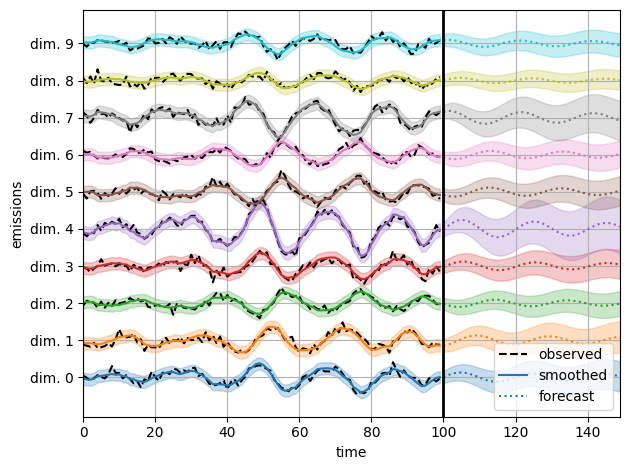

In [15]:
(true_smooth_emissions, true_smooth_emissions_std, 
 true_forecast_emissions, true_forecast_emissions_std) = \
    smooth_and_forecast(true_model, true_params, emissions)

plot_emissions_and_forecast(true_smooth_emissions,
                            true_smooth_emissions_std,
                            true_forecast_emissions,
                            true_forecast_emissions_std)

## Infer the model parameters using HMC

We initialize the model with random parameters, as in the preceding notebook. Here, however, we use HMC to sample from the posterior distribution of parameters given the observed emissions.

### Helper function to run HMC

First, we write a helper function to run HMC, based on the Blackjax examples.

In [10]:
def fit_hmc(model,
            initial_params,
            props,
            key,
            num_samples,
            emissions,
            inputs=None,
            warmup_steps=100,
            num_integration_steps=5,
            verbose=True):
    """Sample parameters of the model using HMC."""
    # Make sure the emissions and inputs have batch dimensions
    batch_emissions = ensure_array_has_batch_dim(emissions, model.emission_shape)
    batch_inputs = ensure_array_has_batch_dim(inputs, model.inputs_shape)

    initial_unc_params = to_unconstrained(initial_params, props)

    # The log likelihood that the HMC samples from
    def _logprob(unc_params):
        params = from_unconstrained(unc_params, props)
        batch_lls = vmap(partial(model.marginal_log_prob, params))(batch_emissions, batch_inputs)
        lp = model.log_prior(params) + batch_lls.sum()
        lp += log_det_jac_constrain(params, props)
        return lp

    # Initialize the HMC sampler using window_adaptation
    warmup = blackjax.window_adaptation(blackjax.hmc,
                                        _logprob,
                                        num_integration_steps=num_integration_steps,
                                        progress_bar=verbose)
    init_key, key = jr.split(key)
    (hmc_initial_state, hmc_params), _ = warmup.run(init_key, initial_unc_params, num_steps=warmup_steps)
    hmc_kernel = blackjax.hmc(_logprob, **hmc_params).step

    @jit
    def hmc_step(hmc_state, step_key):
        next_hmc_state, _ = hmc_kernel(step_key, hmc_state)
        params = from_unconstrained(hmc_state.position, props)

        # Compute the log joint probability using the constrained params
        # Note: this is a bit inefficient because we compute the log probability twice,
        # once with the constrained params and once with the unconstrained. However, the
        # log prob with the constrained params is easier to compare to the true log prob. 
        lp = vmap(partial(model.marginal_log_prob, params))(batch_emissions, batch_inputs).sum()
        lp += model.log_prior(params)
        return next_hmc_state, params, lp

    # Start sampling
    log_probs = []
    samples = []
    hmc_state = hmc_initial_state
    pbar = progress_bar(range(num_samples)) if verbose else range(num_samples)
    for _ in pbar:
        step_key, key = jr.split(key)
        hmc_state, params, lp = hmc_step(hmc_state, step_key)
        log_probs.append(lp)
        samples.append(params)

    # Combine the samples into a single pytree
    return pytree_stack(samples), jnp.array(log_probs)


## Call HMC

In [11]:
# Plot predictions from a random, untrained model
init_key, hmc_key = jr.split(jr.PRNGKey(42))
model = LinearGaussianConjugateSSM(state_dim, emission_dim)
params, param_props = model.initialize(init_key)

sample_size = 1000
param_samples, lps = fit_hmc(model, 
                             params, 
                             param_props, 
                             hmc_key, 
                             sample_size, 
                             emissions, 
                             num_integration_steps=5,
                             warmup_steps=10)

Running window adaptation


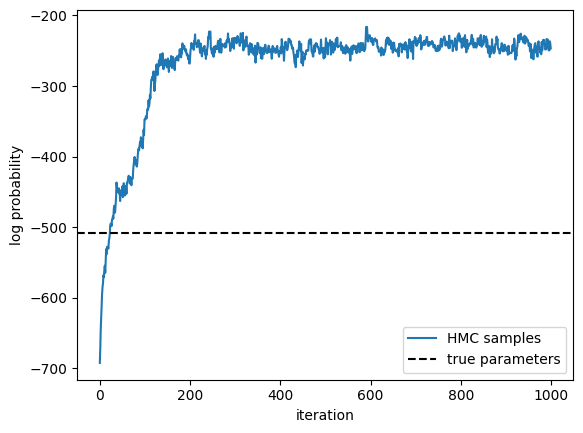

In [13]:
plt.plot(lps, label="HMC samples")
true_lp = true_model.marginal_log_prob(true_params, emissions) \
    + true_model.log_prior(true_params)
    
plt.axhline(true_lp, 
            color="black", linestyle="--", label="true parameters")
plt.xlabel("iteration")
plt.ylabel("log probability")
plt.legend()

## Visualize predictions with samples from the posterior

We use the [law of total variance](https://en.wikipedia.org/wiki/Law_of_total_variance) to approximate the variance of the smoothed and forecast emissions under the posterior.

In [18]:
(smooth_emissions_samples, smooth_emissions_std_samples, 
 forecast_emissions_samples, forecast_emissions_std_samples) = \
    vmap(lambda params: smooth_and_forecast(model, params, emissions))(param_samples)

# Compute the mean and standard deviation of the samples
burnin = 200
est_smooth_emissions = jnp.mean(smooth_emissions_samples[burnin:], axis=0)
est_forecast_emissions = jnp.mean(forecast_emissions_samples[burnin:], axis=0)
est_smooth_emissions_std = jnp.sqrt(
    jnp.mean(smooth_emissions_std_samples[burnin:] ** 2, axis=0) + 
    jnp.var(smooth_emissions_samples[burnin:], axis=0))
est_forecast_emissions_std = jnp.sqrt(
    jnp.mean(forecast_emissions_std_samples[burnin:] ** 2, axis=0) + 
    jnp.var(forecast_emissions_samples[burnin:], axis=0))


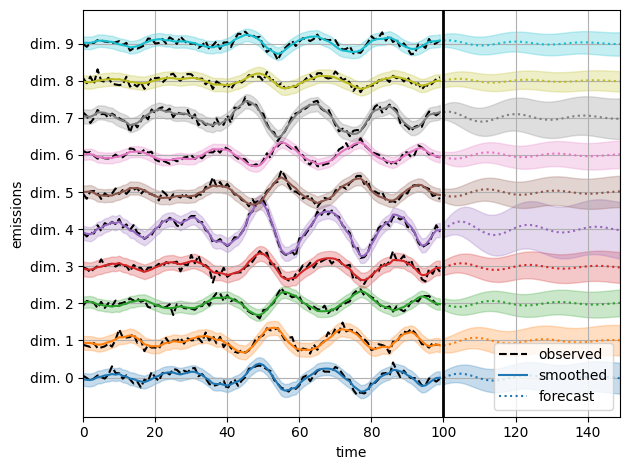

In [19]:
plot_emissions_and_forecast(est_smooth_emissions,
                            est_smooth_emissions_std,
                            est_forecast_emissions,
                            est_forecast_emissions_std)

## Use HMC to infer posterior over a subset of the parameters

We freeze the transition parameters and initial parameters, so that only covariance matrices are learned.
This is useful for structural time series models (see e.g., [sts-jax](https://github.com/probml/sts-jax) library, 
which builds on dynamax.).


In [21]:
# Freeze transition parameters and initial parameters, so that only covariance matrices are learned
init_key, hmc_key = jr.split(jr.PRNGKey(42))
model = LinearGaussianConjugateSSM(state_dim, emission_dim)
params, param_props = model.initialize(
    init_key,                                                                                           #   emission_weights=true_params.emissions.weights,
    emission_weights=true_params.emissions.weights,
    emission_bias=true_params.emissions.bias
)

# Set transition parameters and initial parameters to true values and mark as frozen
param_props.emissions.weights.trainable = False
param_props.emissions.bias.trainable = False

In [23]:
sample_size = 1000
param_samples, lps = fit_hmc(model, 
                             params, 
                             param_props, 
                             hmc_key,
                             sample_size, 
                             emissions, 
                             num_integration_steps=5,
                             warmup_steps=10)

Running window adaptation


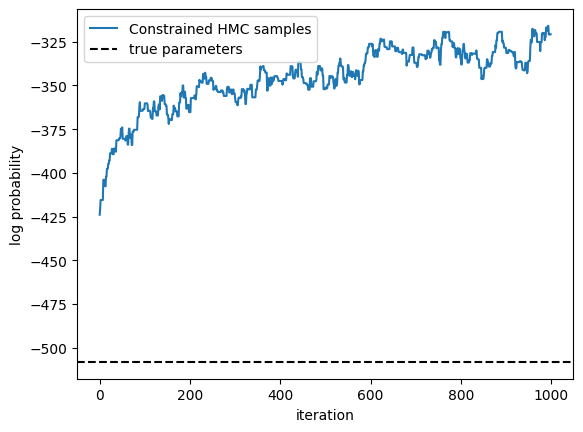

In [27]:
plt.plot(lps, label="Constrained HMC samples")
true_lp = true_model.marginal_log_prob(true_params, emissions) \
    + true_model.log_prior(true_params)
    
plt.axhline(true_lp, 
            color="black", linestyle="--", label="true parameters")
plt.xlabel("iteration")
plt.ylabel("log probability")
plt.legend()

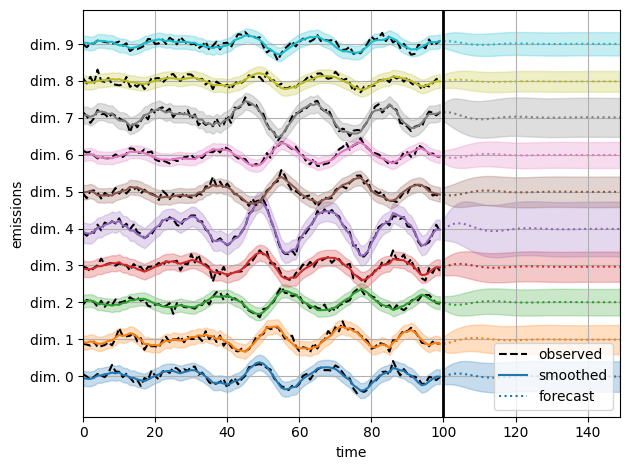

In [26]:
(smooth_emissions_samples, smooth_emissions_std_samples, 
 forecast_emissions_samples, forecast_emissions_std_samples) = \
    vmap(lambda params: smooth_and_forecast(model, params, emissions))(param_samples)

# Compute the mean and standard deviation of the samples
burnin = 200
est_smooth_emissions = jnp.mean(smooth_emissions_samples[burnin:], axis=0)
est_forecast_emissions = jnp.mean(forecast_emissions_samples[burnin:], axis=0)
est_smooth_emissions_std = jnp.sqrt(
    jnp.mean(smooth_emissions_std_samples[burnin:] ** 2, axis=0) + 
    jnp.var(smooth_emissions_samples[burnin:], axis=0))
est_forecast_emissions_std = jnp.sqrt(
    jnp.mean(forecast_emissions_std_samples[burnin:] ** 2, axis=0) + 
    jnp.var(forecast_emissions_samples[burnin:], axis=0))

plot_emissions_and_forecast(est_smooth_emissions,
                            est_smooth_emissions_std,
                            est_forecast_emissions,
                            est_forecast_emissions_std)

## Conclusion

With Dynamax, it's fairly straightforward to run black-box MCMC routines like HMC to approximate the posterior distribution over model parameters. You just plug in the marginal log probability, since the filtering algorithms are differentiable in Dynamax! 